# This is a document that tries keras on jupyter notebook

## Several notes for 11.17
1. Normalizing input data is essential
2. for categorical result, even though there are only two categories, use multi output and softmax. This is necessary as for calculating output in real cases, there are more variables to compare to, thus higher security of a good result.
3. From my guesses, using BN after concatenating two different vectors might alleviate the fitting effort during training, but this remain to be seen
4. Design the network structure with your heart, dude!

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
import re
from gensim.models.wrappers.fasttext import FastText as FT_wrapper
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add, subtract, dot, multiply
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.suptitle(self.title, fontsize=24)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        try:
            val_acc = logs['val_acc']
        except:
            val_acc = logs['val_mean_squared_error']    
        try:
            acc = logs['acc']
        except:
            acc = logs['mean_squared_error']
        if epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        elif epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 2
VisualizeCallback.title = "plot"

In [3]:
def pad_vector_sequence(sequences, max_len): # pad before and truncate after
    padded_sequences = []
    for seq in sequences:
        seq_len = seq.shape[0]
        vec_len = seq.shape[1]
        if max_len > seq_len:
            zeros = np.zeros((max_len - seq_len, 64))
            new_seq = np.vstack([zeros, seq])
        else:
            new_seq = seq[:max_len]
        padded_sequences.append(new_seq)
    return np.array(padded_sequences)

In [4]:
def is_desired_letter(char):
    return ord(char) >= 97 and ord(char) < 123 or ord(char) >= 48 and ord(char) < 58 or ord(char) == ord(" ")


# return even number of 0 and 1 if is_even_result is True
def get_train_data(train_portion, is_even_result=True, is_neg_1_as_0=False, is_second_round_data=False):
    np.random.seed(7)
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("../input/kickstarter_train.csv")
    train_texts_and_results = train_data.iloc[:, [2, -1]]
    # do preliminary preprocessing:remove all symbols and split to words lists
    train_data["desc"] = [[char for char in str(text).lower() if is_desired_letter(char)] for
                          text in train_data["desc"]]
    train_data["desc"] = [''.join(text).split() for text in train_data["desc"]]
    # load word vector
    wv_path = "word2vec/w2v_data/fasttext_wv_64"
    wv_model = KeyedVectors.load(wv_path)
    # remove words that cannot be expressed
    train_data["desc"] = [[word for word in text if word in wv_model] for text in train_data["desc"]]
    # word 2 vector
    train_data["desc"] = [np.array(list(map(wv_model.word_vec, text))) for text in train_data["desc"]]
    # remove too short desc
    drop_index = []
    for i in range(len(train_data)):
        if train_data.iloc[i, 2].shape[0] <= 2:
            drop_index.append(i)
    train_data = train_data.drop(train_data.index[drop_index])
    
    if is_even_result:
        # count 0 and drop some until sample of 1 = sample of 0
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        drop_zero_num = status_count[0] - status_count[1]
        drop_zero_p = drop_zero_num / float(status_count[0])
        drop_index = []
        for i in range(len(train_data)):
            if train_data.iloc[i, -1] == 0:
                if np.random.uniform(low=0, high=1) < drop_zero_p:
                    drop_index.append(i)
        train_data = train_data.drop(train_data.index[drop_index])
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        print(float(status_count[0]) / float(status_count[1]))
        # shuffle the whole data
        train_data = train_data.sample(frac=1).reset_index(drop=True)
    
    # tokenize all countries
    # load dictionary or genrate one online
    try:
        country_dict = Dictionary.load("../num_model/num_data/country_dict.pkl")
        print("loading country dictionary successful from disk")
    except:
        print("No country dictionary available, generating from data")
        country_dict = Dictionary([train_data.iloc[:, 6]])
        country_dict.save("../num_model/num_data/country_dict.pkl")
        print("new dictionary saved to num_data")
    # start tokenization
    try:
        train_data.iloc[:, 6] = np.array(list(map(country_dict.token2id.get, train_data.iloc[:, 6]))) # map gives extra speed~
    except:
        print("Warning!!! A country that does not exist in current dictionary!!!")
    
    # spliting input output
    if is_second_round_data == False:
        # get split point for train and test data
        split_point = int(train_portion * len(train_data))
        # get descriptions data
        train_texts = np.array(train_data.iloc[:split_point, 2])
        test_texts = np.array(train_data.iloc[split_point:, 2])
        # get country data
        train_countries = np.array(train_data.iloc[:split_point, 6])
        test_countries = np.array(train_data.iloc[split_point:, 6])
        # get result data
        train_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[:split_point, -1]])
        test_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[split_point:, -1]])
    else:
        # get split point for train and test data
        split_point = int(train_portion * len(train_data))
        split_point_2 = int(train_portion * len(train_data) * 2)
        # get descriptions data
        train_texts = np.array(train_data.iloc[split_point:split_point_2, 2])
        test_texts = np.array(train_data.iloc[split_point_2:, 2])
        # get country data
        train_countries = np.array(train_data.iloc[split_point:split_point_2, 6])
        test_countries = np.array(train_data.iloc[split_point_2:, 6])
        # get result data
        train_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[split_point:split_point_2, -1]])
        train_results_single = np.array(train_data.iloc[split_point:split_point_2, -1])
        test_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[split_point_2:, -1]])
        test_results_single = np.array(train_data.iloc[split_point_2:, -1])
        if is_neg_1_as_0:
            train_results_single = np.array([1 if item == 1 else -1 for item in train_results_single])
            test_results_single = np.array([1 if item == 1 else -1 for item in test_results_single])
            train_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in train_results_double])
            test_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in test_results_double])
    
    return [train_texts, train_countries, train_results_double, train_results_single], [test_texts, test_countries, test_results_double, test_results_single]

In [5]:
# get training testing data from disk
train_portion = 0.45
train_data, test_data = get_train_data(train_portion, is_second_round_data=True)
print("data grabbed")

1.0003763098477392
loading country dictionary successful from disk
data grabbed


In [6]:
# truncate and pad input sequences
max_desc_length = 35
train_data[0] = pad_vector_sequence(train_data[0], max_len=max_desc_length)
test_data[0] = pad_vector_sequence(test_data[0], max_len=max_desc_length)
print("padding finished")

padding finished


# Let's stack the conv1D network and rnn network
__the rnn network and conv1d network both can only achieve around 63 percent of accurate prediction__

In [7]:
def step_func(x):
    return K.hard_sigmoid(100000000000*x)

def append_classifier_layer(model):
    new_output = subtract(inputs=[model.layers[-2].output, model.layers[-1].output])
    new_output = Activation(step_func, name="step_func")(new_output)
    model = Model(inputs=[model.input], outputs=[new_output])

    return model

In [8]:
# load and freeze rnn_models
# append a classifier layer to get step output 1 and 0
desc_rnn_model = load_model("desc_data/desc_rnn_model_LSTM32_ResFork_D32_tanh_DO.25_BNOut_sigmoidacc: 0.632893075142.hdf5")
desc_rnn_model.layers.pop()
desc_rnn_model.layers.pop()
desc_rnn_model = append_classifier_layer(desc_rnn_model)
for layer in desc_rnn_model.layers:
    layer.trainable = False
desc_rnn_model.trainable = False # this step is necessary to freeze the lstm layer!!!
desc_rnn_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
desc_rnn_model.summary()

# load and freeze conv models
# append a classifier layer to step output 1 and 0
desc_conv_model = load_model("desc_data/desc_conv_model_C32_C32.5_DO.25_MP4_DO.25_ResFork_0.5 acc: 0.622579456944.hdf5")
desc_conv_model.layers.pop()
desc_conv_model.layers.pop()
desc_conv_model.layers.pop()
desc_conv_model = append_classifier_layer(desc_conv_model)
for layer in desc_conv_model.layers:
    layer.trainable = False
desc_conv_model.trainable = False
desc_conv_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
desc_conv_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35, 64)       0                                            
__________________________________________________________________________________________________
Recurent_1 (LSTM)               (None, 32)           12416       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32)           128         Recurent_1[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32)           0        

In [9]:
# evaluate both models:
conv_scores = desc_conv_model.evaluate(x=[test_data[0]], y=[test_data[3]])
rnn_scores = desc_rnn_model.evaluate(x=[test_data[0]], y=[test_data[3]])
print("conv model has acc: ", conv_scores[1])
print("rnn model has acc: ", rnn_scores[1])

6911/6911 [==============================] - 1s 164us/step
conv model has acc:  0.616553320689
rnn model has acc:  0.627839675931


# set up prediction and factor training data and testing data

In [10]:
# set up training and testing data for factor model
def setFactorData(model_1, model_2, data_input, is_even_result=False):
    # set random seed to get replicable result
    np.random.seed(7)
    # start processing
    data = [0]*len(data_input)
    for i, _ in enumerate(data_input):
        data[i] = data_input[i].copy()
    model_1_result = [item for item in model_1.predict_on_batch(data[0])]
    model_2_result = [item for item in model_2.predict_on_batch(data[0])]
    factor_data = []
    delete_index = []
    model_1_right = 0
    model_2_right = 0
    for i, result in enumerate(data[3]):
        if model_1_result[i] == model_2_result[i]:
            delete_index.append(i)
        elif model_1_result[i] == result and model_2_result[i] != result:
            factor_data.append([1, 0])
            model_1_right += 1
        else:
            factor_data.append([0, 1])
            model_2_right += 1
    for i, _ in enumerate(data):
        data[i] = np.delete(data[i], delete_index, axis=0)
    data.append(np.array(factor_data))
    # if is_even_result and model_1_right != model_2_right:
    #     delete_index = []
    #     max_right = max(model_1_right, model_2_right)
    #     more_right = abs(model_1_right - model_2_right)
    #     if model_1_right > model_2_right:
    #         good_model = 1
    #     else:
    #         good_model = 0
    #     p = float(more_right) / max_right
    #     for i, item in enumerate(factor_data):
    #         if item[0] == good_model:
    #             if np.random.uniform(low=0, high=1) < p:
    #                 delete_index.append(i)
    #     for i, _ in enumerate(data):
    #         data[i] = np.delete(data[i], delete_index, axis=0)
    return data

train_prediction_data = setFactorData(desc_rnn_model, desc_conv_model, train_data, is_even_result=True)
test_prediction_data = setFactorData(desc_rnn_model, desc_conv_model, test_data, is_even_result=True)

# print data distribution
rnn = len([1 for item in train_prediction_data[4] if item[0] == 1])
conv = len([0 for item in train_prediction_data[4] if item[0] == 0])
print("the ratio of rnn_right and conv_right in the extracted dataset is: ", rnn / float(conv))

the ratio of rnn_right and conv_right in the extracted dataset is:  1.0022378516624042


# play with direct end to end prediction factor learning
## lesson learnt: do not set too high regulation on activity or weight, which might keep network from actually learning

In [13]:
# start stacking
def DenseNetCell(dense_in, dropout_level=0.25, res_num=1):
    this_input = dense_in
    for i in range(res_num):
        x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(0.001))(this_input)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x) 
        x = Dropout(dropout_level)(x)
        res_out = add(inputs=[this_input, x])
        this_input = BatchNormalization()(res_out)
    dense_out = Dense(1)(this_input)
    return dense_out

# get the label input for later use
desc_input = Input(shape=(35, 64))
rnn_out = desc_rnn_model(desc_input)
conv_out = desc_conv_model(desc_input)
label_out = concatenate(inputs=[rnn_out, conv_out])

# generate model for descriptions + country
x = Conv1D(kernel_size=3, filters=64, activation="relu")(desc_input)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)
x = LSTM(units=32, dropout=0.2, name="Recurent_1")(x)
x = BatchNormalization()(x)
fork_in = Dropout(0.2)(x)
# fork network for isolately decide prediction factor for rnn and conv model
fork_out = concatenate(inputs=[DenseNetCell(fork_in, dropout_level=0.25, res_num=5), 
                               DenseNetCell(fork_in, dropout_level=0.25, res_num=5)])
factor_output = BatchNormalization()(fork_out)
factor_output = Activation("softmax")(fork_out)

desc_stack_factor_model = Model(inputs=[desc_input], outputs=[factor_output])
plot_model(desc_stack_factor_model, show_shapes=True, to_file="temp.png")
print("model building finished\n", desc_stack_factor_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35, 64)       0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 33, 64)       12352       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 33, 64)       132         conv1d_2[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 33, 64)       0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
Recurent_1

<IPython.core.display.Javascript object>


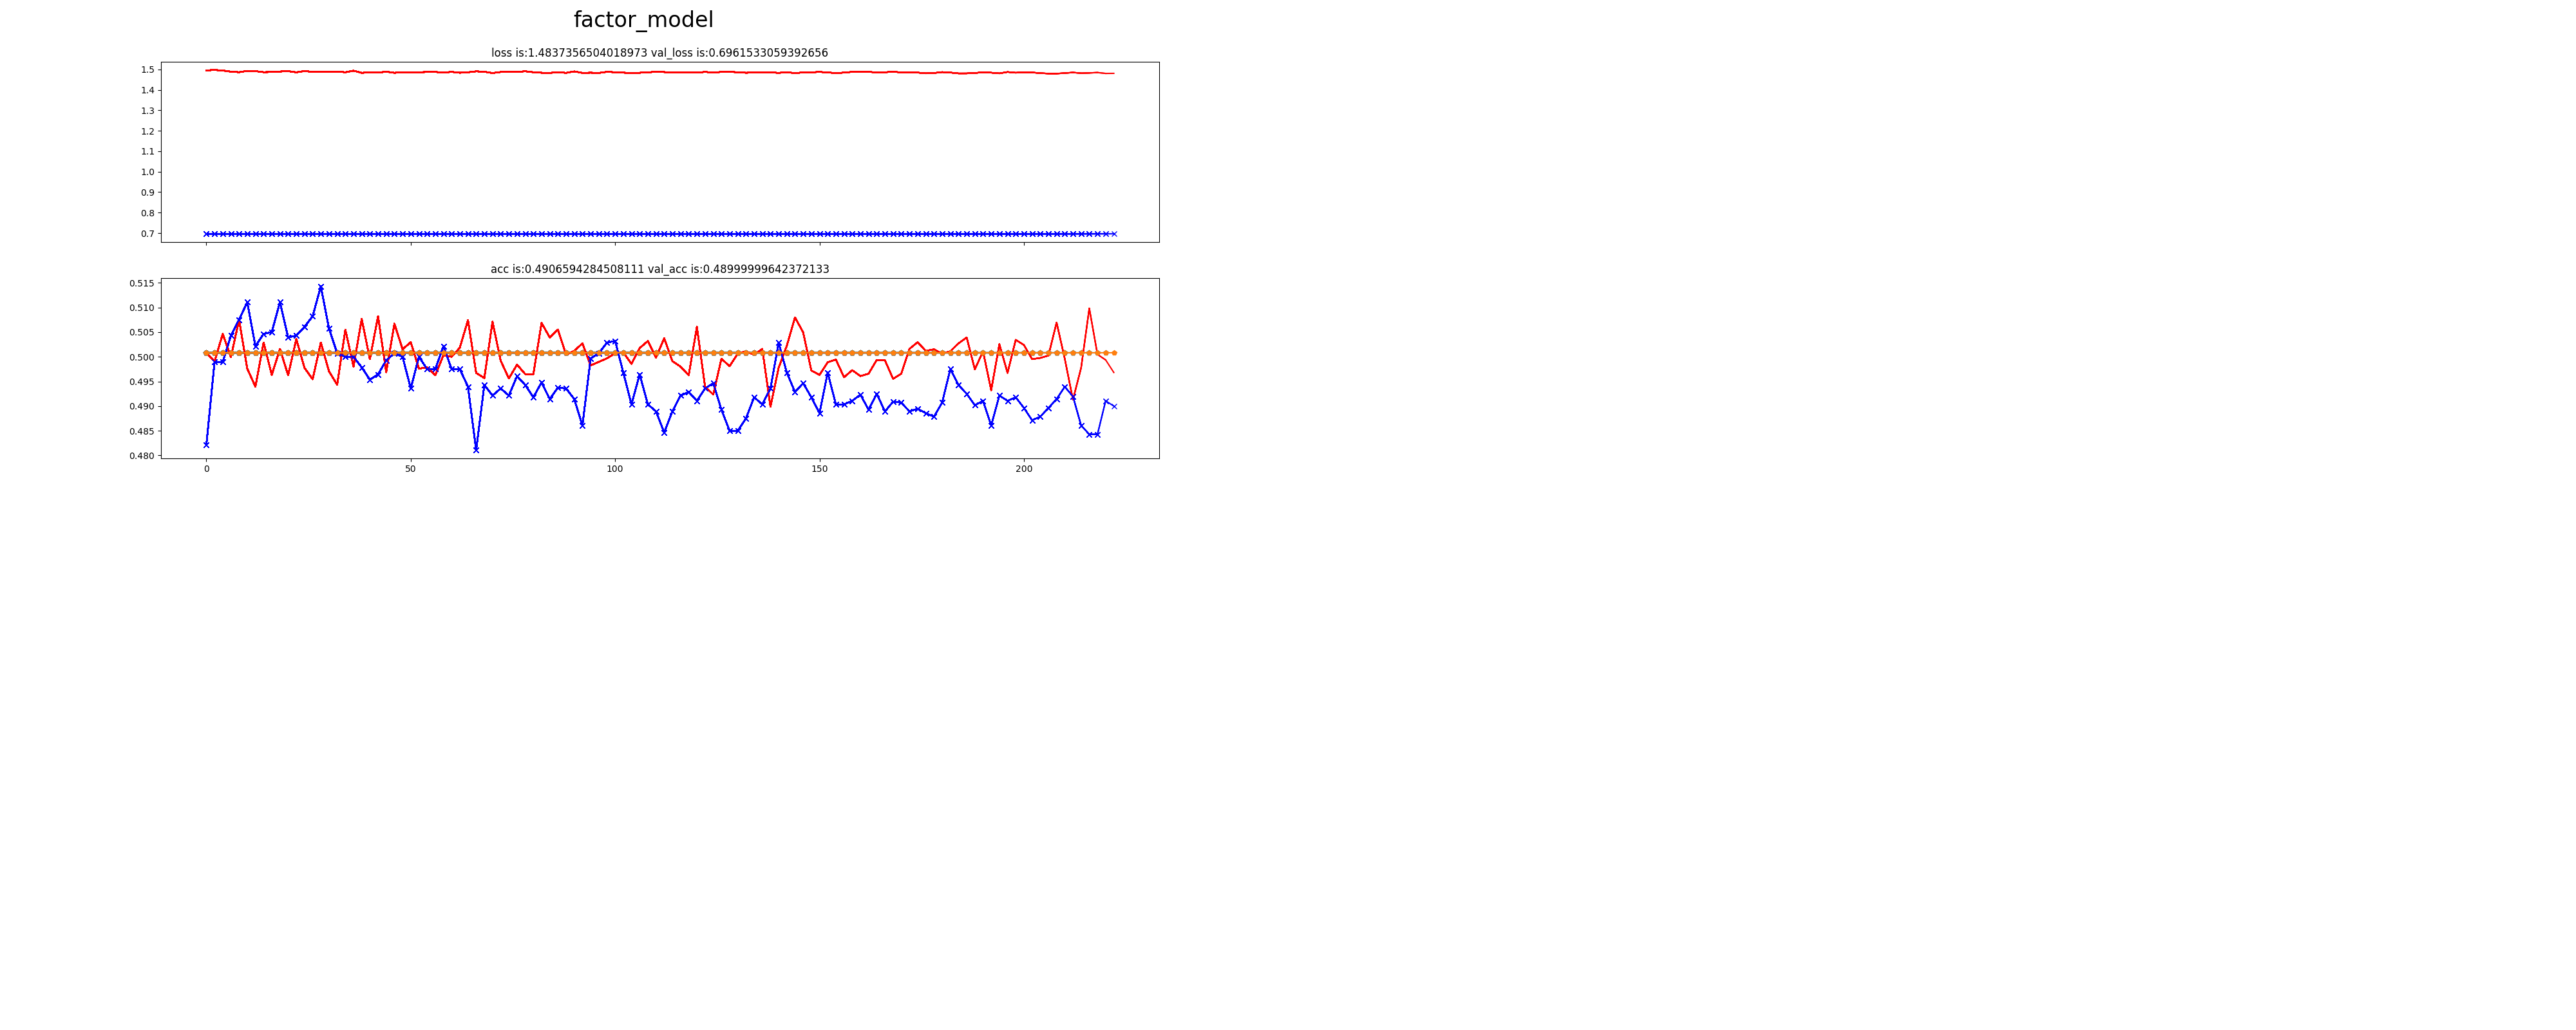

KeyboardInterrupt: 

In [20]:
# do training
VisualizeCallback.title = "factor_model"
VisualizeCallback.interval = 2
desc_stack_factor_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=["accuracy"])
desc_stack_factor_model.fit(train_prediction_data[0], train_prediction_data[4], epochs=1000, batch_size=512, shuffle=True,
                  verbose=0, validation_data=[test_prediction_data[0], test_prediction_data[4]], 
                  callbacks=[ReduceLROnPlateau(patience=3, min_lr=0.0000005, cooldown=30), VisualizeCallback])


scores = desc_stack_factor_model.evaluate(x=[test_data[0]], y=[test_data[2]])
desc_stack_factor_model.save("desc_data/desc_factor_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

In [18]:
result = desc_stack_factor_model.predict_on_batch(x=[test_prediction_data[0]])
list(zip(result,test_prediction_data[4]))

[(array([ 0.49941176,  0.5005883 ], dtype=float32), array([0, 1])),
 (array([ 0.49980208,  0.50019789], dtype=float32), array([1, 0])),
 (array([ 0.49976274,  0.50023723], dtype=float32), array([1, 0])),
 (array([ 0.50012803,  0.499872  ], dtype=float32), array([1, 0])),
 (array([ 0.49978876,  0.50021118], dtype=float32), array([0, 1])),
 (array([ 0.49975085,  0.50024915], dtype=float32), array([1, 0])),
 (array([ 0.49967888,  0.50032103], dtype=float32), array([0, 1])),
 (array([ 0.49984932,  0.50015068], dtype=float32), array([1, 0])),
 (array([ 0.49972984,  0.50027007], dtype=float32), array([0, 1])),
 (array([ 0.49982521,  0.50017482], dtype=float32), array([0, 1])),
 (array([ 0.49986362,  0.50013644], dtype=float32), array([1, 0])),
 (array([ 0.49996909,  0.50003088], dtype=float32), array([0, 1])),
 (array([ 0.49989623,  0.50010371], dtype=float32), array([0, 1])),
 (array([ 0.49992269,  0.50007731], dtype=float32), array([1, 0])),
 (array([ 0.49981529,  0.50018466], dtype=float3

In [19]:
stack_final_out = dot(inputs=[label_out, factor_output], axes=1)
desc_stack_model = Model(inputs=[desc_input], outputs=[stack_final_out])
desc_stack_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
desc_stack_model.evaluate(x=[test_data[0]], y=[test_data[3]])

6911/6911 [==============================] - 5s 669us/step


[29.553911340752414, 0.61510635209728681]

# play with complex feature discriminating stacked layer
> notice!!: originally, I tried to directly dot the factor output with labels and train them, however, the sneaky lazy neural network bypassed everything by simply setting factor output to purely rely on one network....
> It is necessary to train the factor isolately

In [11]:
# start stacking
def forkResCell(fork_in, dropout_level=0.25):
    x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(0.01))(fork_in)
    x = BatchNormalization()(x)
    x = Activation("tanh")(x) 
    res = Dropout(dropout_level)(x)
    res_out = add(inputs=[fork_in, res])
    res_out = BatchNormalization()(res_out)
    fork_out = Dense(1)(res_out)
    return fork_out

def getLayerOutput(model_input, model, layer_num):
    x = model.layers[1](model_input)
    for i in range(2, layer_num + 1):
        x = model.layers[i](x)
    return x

# get the label input
desc_input = Input(shape=(35, 64))
rnn_out = desc_rnn_model(desc_input)
conv_out = desc_conv_model(desc_input)
label_out = concatenate(inputs=[rnn_out, conv_out])

# get poportion calculated from features (hopefully based on the feature extraction quality)
# rnn
rnn_feature_model = Model(inputs=[desc_input], outputs=[getLayerOutput(desc_input, desc_rnn_model, 3)], name="rnn_feature_model")# dropout output of lstm
rnn_feature = rnn_feature_model(desc_input)
x = Dense(32, activation="relu", activity_regularizer=l2(0.01))(rnn_feature)
x = BatchNormalization()(x)
rnn_feature = Dropout(0.2)(x) # normalized to vec_len 64
# conv
conv_feature_model = Model(inputs=[desc_input], outputs=[getLayerOutput(desc_input, desc_conv_model, 10)], name="conv_feature_model") # dropout output of flattened maxpooling
conv_feature = conv_feature_model(desc_input)
x = Dense(32, activation="relu", activity_regularizer=l2(0.01))(conv_feature)
x = BatchNormalization()(x)
conv_feature = Dropout(0.2)(x)
# subtract each feature to get a comparison:
compare = subtract(inputs=[rnn_feature, conv_feature])
x = BatchNormalization()(compare)
x = Activation("tanh")(x)
compare = Dropout(0.2)(x)
# get factors vector
x = Dense(64, activity_regularizer=l2(0.01))(compare)
x = BatchNormalization()(x)
x = Activation("tanh")(x)
x = Dropout(0.5)(x)
x = Dense(32, activity_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation("tanh")(x)
x = Dropout(0.2)(x)
factor_output = Dense(2, activation="softmax")(x)

desc_stack_model = Model(inputs=[desc_input], outputs=[factor_output])
plot_model(desc_stack_model, show_shapes=True, to_file="temp.png")
print("model building finished\n", desc_stack_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35, 64)       0                                            
__________________________________________________________________________________________________
rnn_feature_model (Model)       (None, 32)           12544       input_1[0][0]                    
__________________________________________________________________________________________________
conv_feature_model (Model)      (None, 224)          12472       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        rnn_feature_model[1][0]          
__________________________________________________________________________________________________
dense_2 (D

<IPython.core.display.Javascript object>


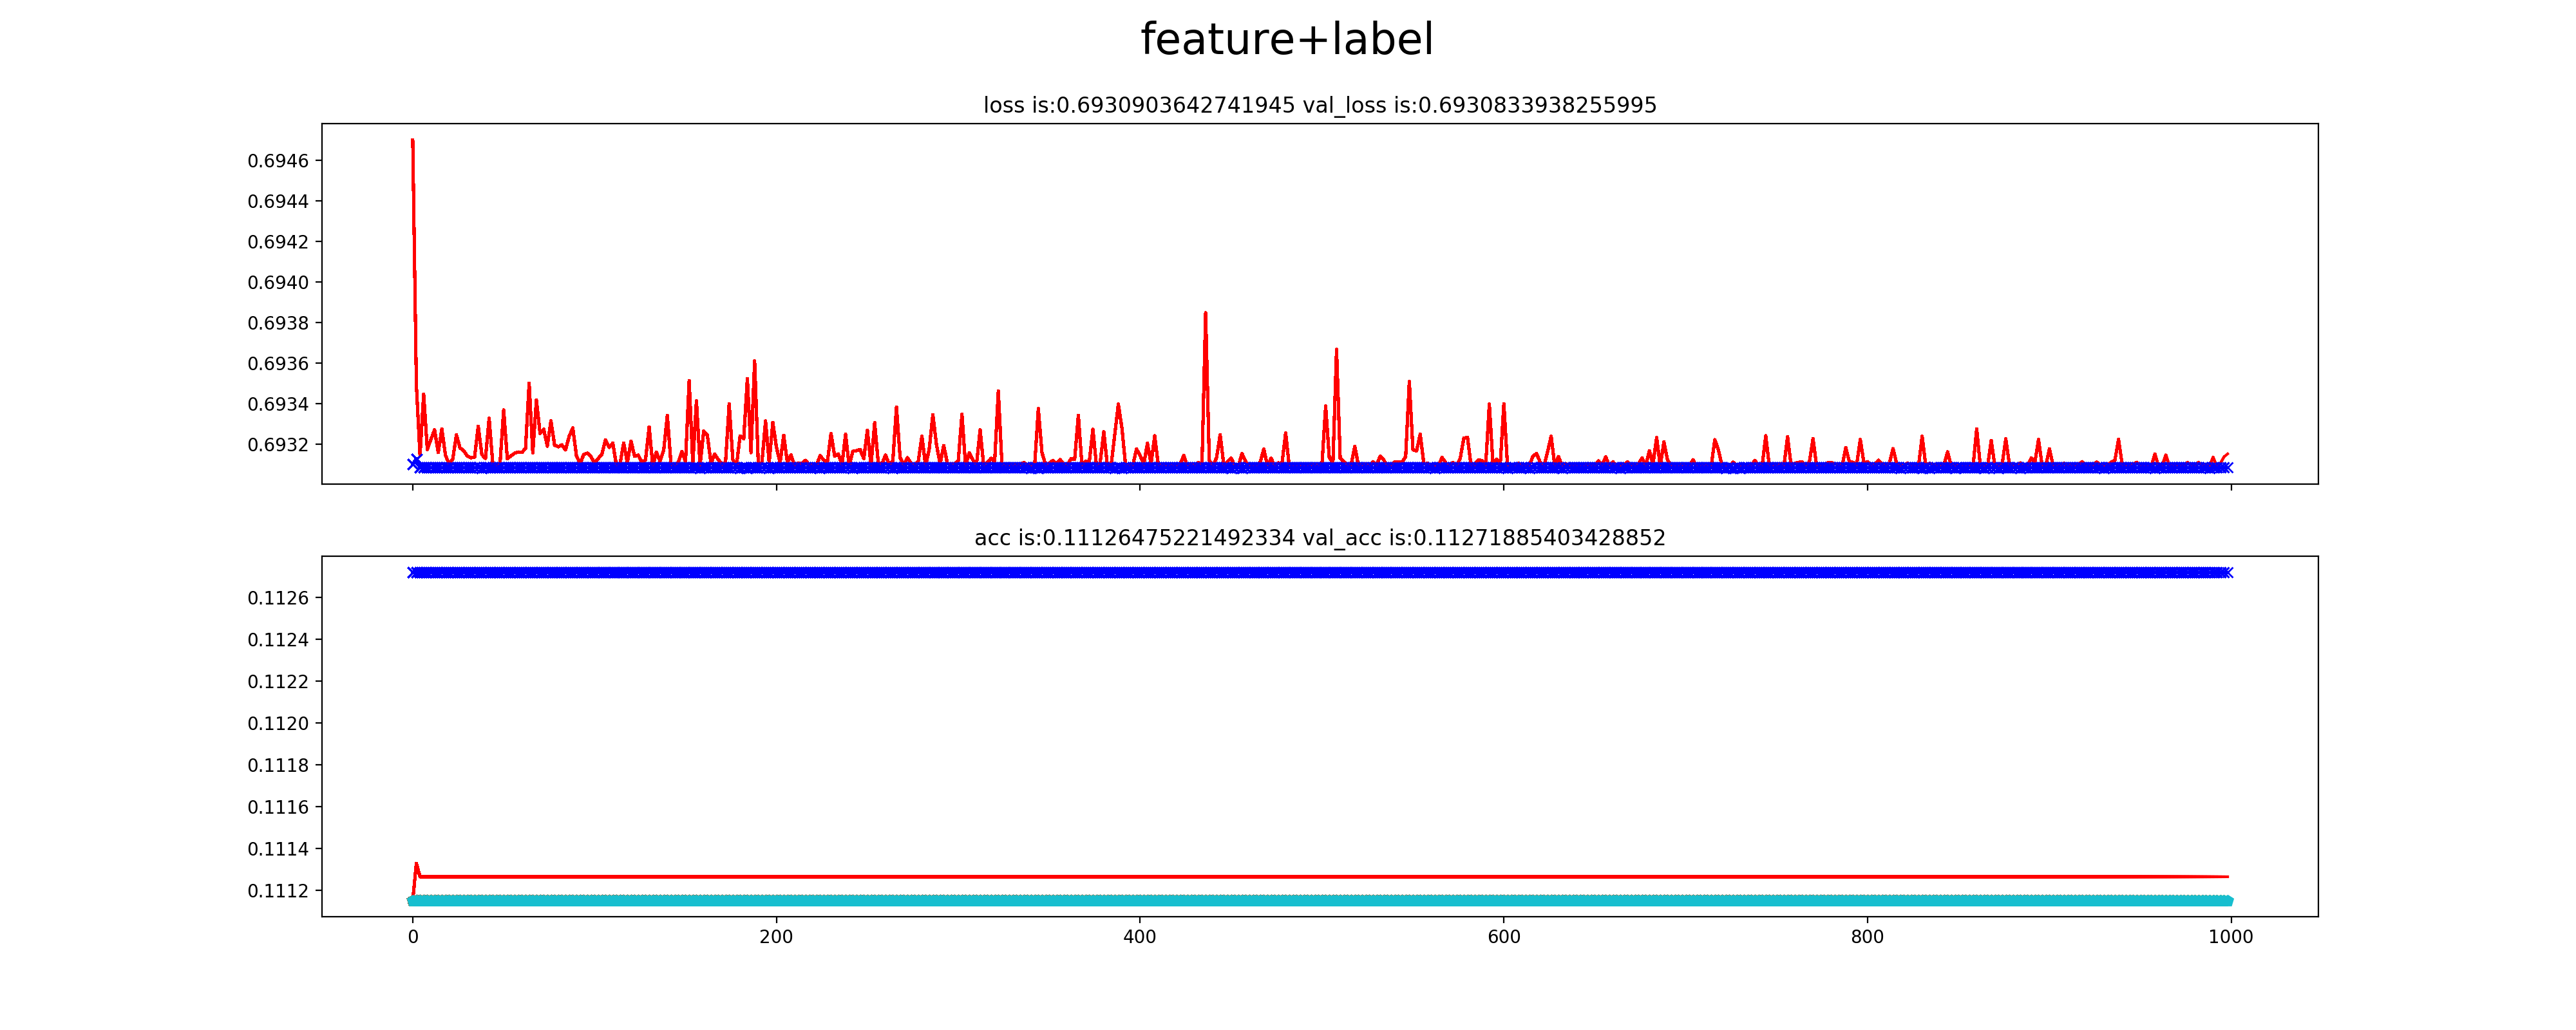

6911/6911 [==============================] - 1s 160us/step


In [14]:
# do training
VisualizeCallback.title = "feature+label"
VisualizeCallback.interval = 2
desc_stack_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
desc_stack_model.fit(train_data[0], train_data[4], epochs=1000, batch_size=512, shuffle=True,
                  verbose=0, validation_data=[test_data[0], test_data[4]], 
                  callbacks=[ReduceLROnPlateau(patience=3, min_lr=0.00001, cooldown=30), VisualizeCallback])


scores = desc_stack_model.evaluate(x=[test_data[0]], y=[test_data[2]])
desc_stack_model.save("desc_data/desc_stack_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

In [20]:
final_out = dot(inputs=[label_out, factor_output], axes=1)
final_stack_model = Model(inputs=[desc_input], outputs=[final_out])
final_stack_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
final_stack_model.evaluate(x=[test_data[0]], y=[test_data[3]])

6911/6911 [==============================] - 2s 351us/step


[29.84868047441282, 0.55635942694437412]

# normal stacking (which does not seem to work well at all...)(well behavior of zero overfit……)

In [169]:
# start stacking
def forkResCell(fork_in, dropout_level=0.25):
    x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(0.01))(fork_in)
    x = BatchNormalization()(x)
    x = Activation("tanh")(x) 
    res = Dropout(dropout_level)(x)
    res_out = add(inputs=[fork_in, res])
    res_out = BatchNormalization()(res_out)
    fork_out = Dense(1)(res_out)
    return fork_out

desc_input = Input(shape=(35, 64))
rnn_out = desc_rnn_model(desc_input)
conv_out = desc_conv_model(desc_input)

desc_stack_input = concatenate(inputs=[rnn_out, conv_out])
x = Dense(64, kernel_regularizer=l2(0.01))(desc_stack_input)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = Dropout(0.5)(x)
x = Dense(64, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = Dropout(0.5)(x)
x = Dense(64, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = Dropout(0.5)(x)
x = concatenate([forkResCell(x), forkResCell(x)])
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = Dropout(0.2)(x)
x = Dense(2)(x)
x = BatchNormalization()(x)
desc_stack_output = Activation("sigmoid")(x)

desc_stack_model = Model(inputs=[desc_input], outputs=[desc_stack_output])

print("model building finished\n", desc_stack_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 35, 64)       0                                            
__________________________________________________________________________________________________
model_25 (Model)                (None, 1)            15236       input_15[0][0]                   
__________________________________________________________________________________________________
model_26 (Model)                (None, 1)            117316      input_15[0][0]                   
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 2)            0           model_25[10][0]                  
                                                                 model_26[10][0]                  
__________

<IPython.core.display.Javascript object>


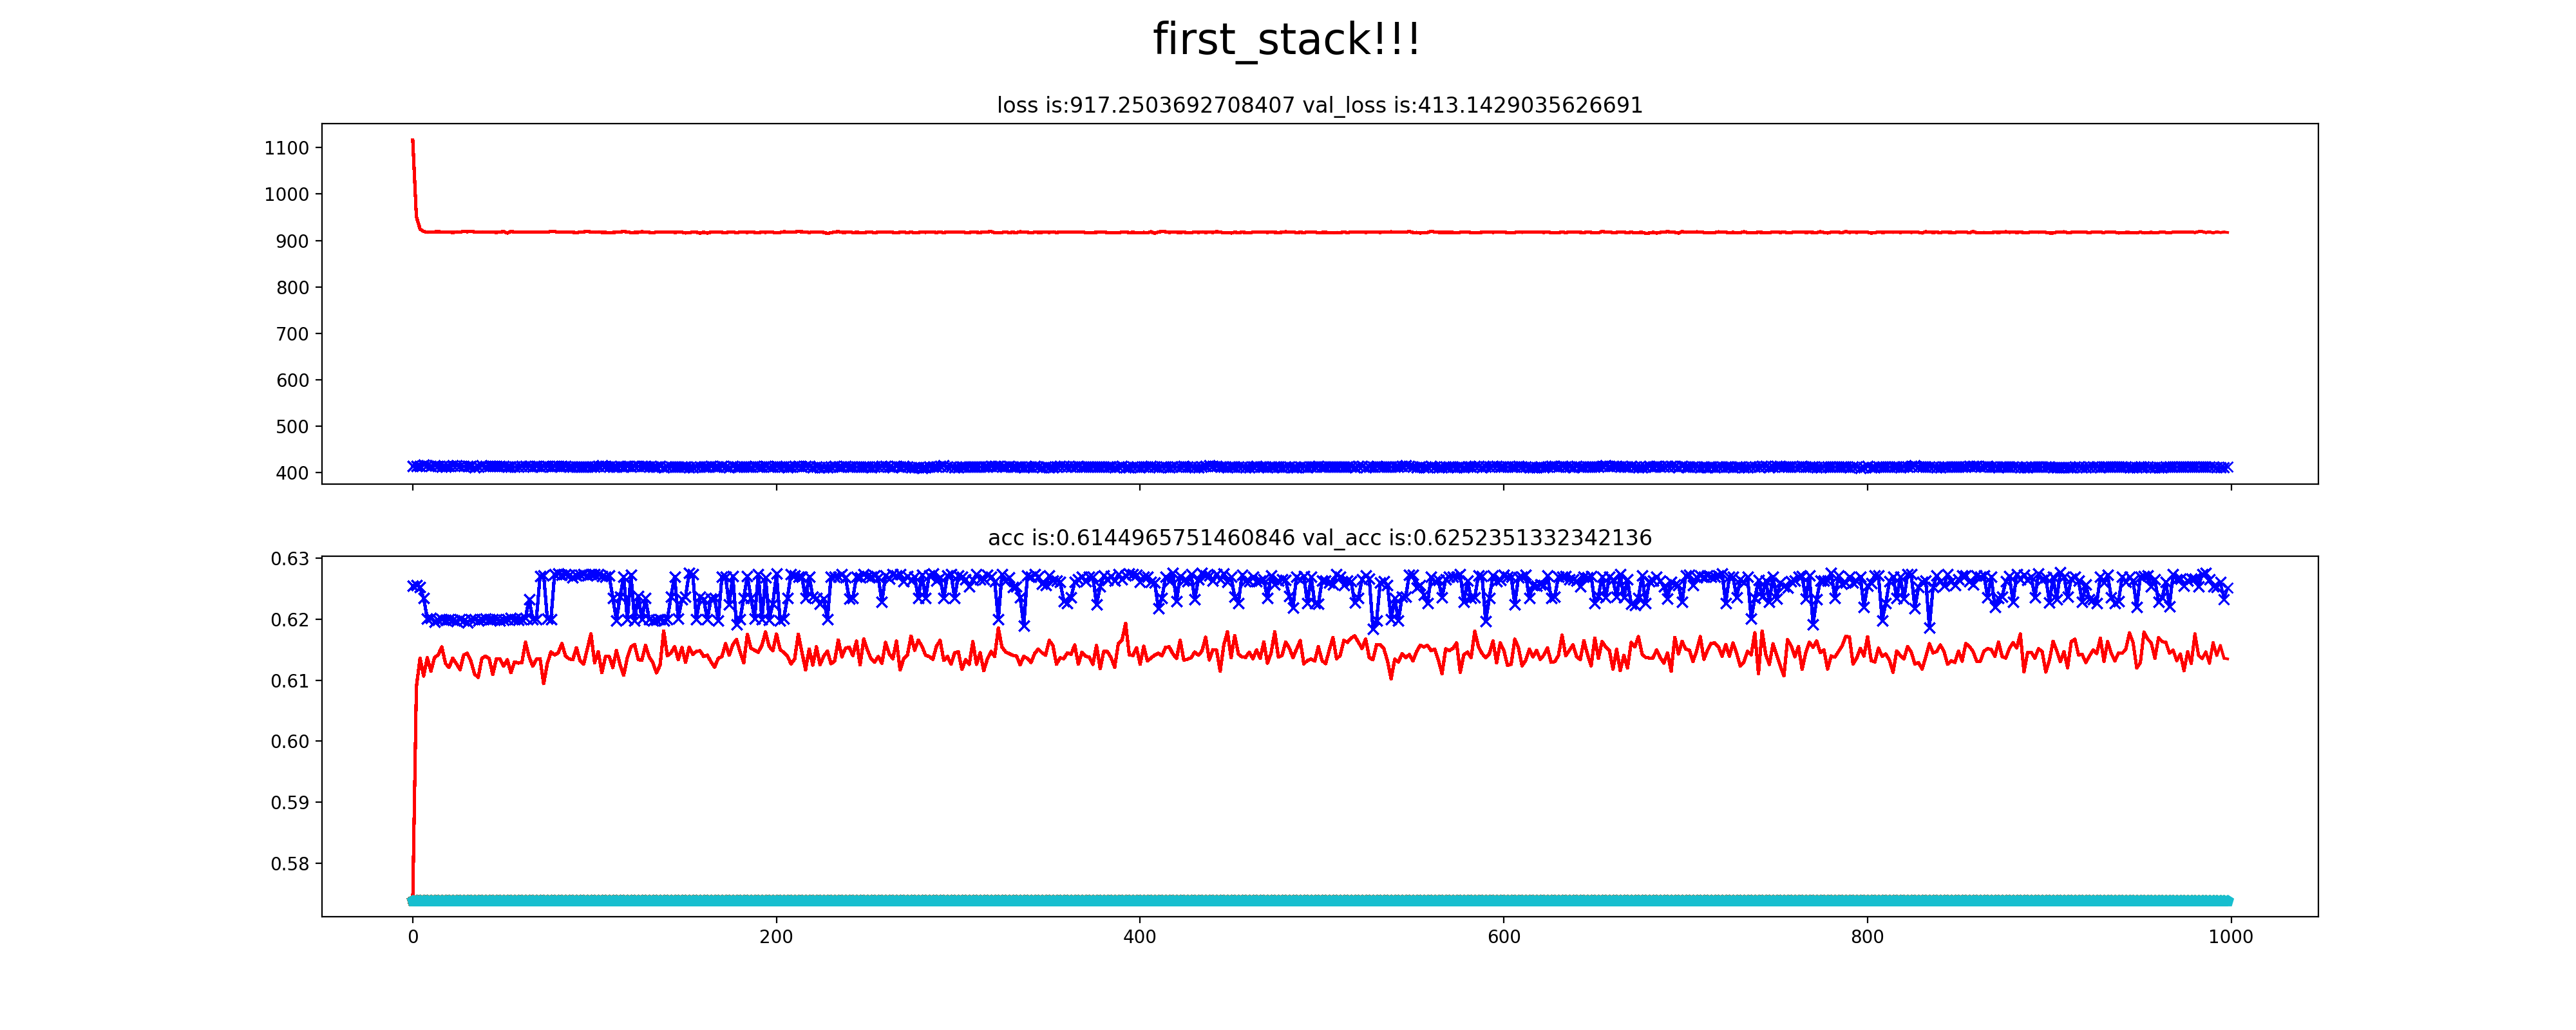

6911/6911 [==============================] - 2s 261us/step


In [172]:
# do training
VisualizeCallback.title = "first_stack!!!"
VisualizeCallback.interval = 2
desc_stack_model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=["accuracy"])
desc_stack_model.fit(train_data[0], train_data[2], epochs=1000, batch_size=512, shuffle=True,
                  verbose=0, validation_data=[test_data[0], test_data[2]], 
                  callbacks=[ReduceLROnPlateau(patience=3, min_lr=0.0001, cooldown=30), VisualizeCallback])


scores = desc_stack_model.evaluate(x=[test_data[0]], y=[test_data[2]])
desc_stack_model.save("desc_data/desc_stack_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

In [165]:
desc_stack_model.layers[4].get_weights()

[array([[  9.12420079e-02,   1.52703151e-01,  -1.82510674e-01,
           1.32536680e-01,   4.76578772e-02,  -1.81597263e-01,
          -1.06272921e-01,  -1.05175503e-01,  -1.24140255e-01,
           8.31115320e-02,   1.34991959e-01,   1.94718108e-01,
           1.28672823e-01,   5.26874177e-02,  -3.18343053e-03,
           1.06373414e-01,   1.88645586e-01,  -1.94473192e-01,
          -2.29258300e-03,  -6.97864592e-02,  -1.78720906e-01,
          -1.11929186e-01,  -1.44944608e-01,  -1.70113623e-01,
          -8.79347615e-04,  -2.44166389e-01,  -6.66019469e-02,
          -1.11218259e-01,   1.34779990e-01,   3.02948221e-03,
          -2.03406706e-01,  -1.11912958e-01,  -1.80571189e-03,
           2.70288795e-01,  -1.98463738e-01,   9.67916027e-02,
          -2.20470697e-01,  -5.38353324e-02,  -1.67667553e-01,
           1.94850132e-01,  -1.98235124e-01,  -2.16509379e-03,
          -1.33786485e-01,  -1.32133991e-01,   5.02010516e-04,
          -2.13049382e-01,   1.74245805e-01,   1.308677

In [18]:
# re-evaluate seperate models to make sure nothing changed
conv_scores = desc_conv_model.evaluate(x=[test_data[0]], y=[test_data[3]])
rnn_scores = desc_rnn_model.evaluate(x=[test_data[0]], y=[test_data[3]])
stack_scores = desc_stack_model.evaluate(x=[test_data[0]], y=[test_data[3]])
print("conv model has acc: ", conv_scores[1])
print("rnn model has acc: ", rnn_scores[1])
print("stack model has acc: ", stack_scores[1])

6911/6911 [==============================] - 1s 145us/step


ValueError: Error when checking target: expected dense_5 to have shape (None, 2) but got array with shape (6911, 1)

In [173]:
get_intermediate_output = K.function(inputs=[desc_stack_model.layers[0].input, K.learning_phase()], outputs=[desc_stack_model.layers[-2].output])
result = get_intermediate_output([test_data[0], 0])


In [174]:
list(zip(result[0], test_data[2]))

[(array([ 0.01927968, -0.01933186], dtype=float32), array([1, 0])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([1, 0])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([1, 0])),
 (array([ 0.01927968, -0.01933186], dtype=float32), array([0, 1])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([1, 0])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([1, 0])),
 (array([ 0.11483251, -0.11488502], dtype=float32), array([1, 0])),
 (array([-0.64960724,  0.64955711], dtype=float32), array([1, 0])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([0, 1])),
 (array([ 0.11483251, -0.11488502], dtype=float32), array([1, 0])),
 (array([-0.64960724,  0.64955711], dtype=float32), array([0, 1])),
 (array([-0.64960724,  0.64955711], dtype=float32), array([0, 1])),
 (array([ 0.57816869, -0.57822061], dtype=float32), array([0, 1])),
 (array([-0.64960724,  0.64955711], dtype=float32), array([1, 0])),
 (array([-0.64960724,  0.64955711], dtype=float3

# dependency check of two network

In [26]:
# get label statistics
label_zeros = 0.0
label_ones = 0.0
for i in test_data[2]:
    if i[0] == 0:
        label_zeros += 1
    else:
        label_ones += 1
all_labels = label_ones + label_zeros

# get prediction statistics
conv_result = [item for item in desc_conv_model.predict_on_batch(test_data[0])]
rnn_result = [item for item in desc_rnn_model.predict_on_batch(test_data[0])]
stack_result = [item for item in desc_stack_model.predict_on_batch(test_data[0])]

In [27]:
# get accuracy prediction statistics
conv_right = len([1 for i, _ in enumerate(conv_result) if conv_result[i] == test_data[2][i][0] ])
conv_wrong = len([0 for i, _ in enumerate(conv_result) if conv_result[i] != test_data[2][i][0]])
rnn_right = len([1 for i, _ in enumerate(conv_result) if rnn_result[i] == test_data[2][i][0]])
rnn_wrong = len([0 for i, _ in enumerate(conv_result) if rnn_result[i] != test_data[2][i][0]])
stack_right = len([1 for i, _ in enumerate(conv_result) if stack_result[i] == test_data[2][i][0]])
stack_wrong = len([0 for i, _ in enumerate(conv_result) if stack_result[i] != test_data[2][i][0]])
both_right = len([1 for i, _ in enumerate(conv_result) if conv_result[i] == rnn_result[i] and conv_result[i] == test_data[2][i][0]])
both_wrong = len([0 for i, _ in enumerate(conv_result) if conv_result[i] == rnn_result[i] and conv_result[i] != test_data[2][i][0]])
same_result = len([1 for i, _ in enumerate(conv_result) if conv_result[i] == rnn_result[i]])

def model_comparer(result_1, right_1, wrong_1, name_1, result_2, right_2, wrong_2, name_2, true_result):
    both_right = len([1 for i, _ in enumerate(result_1) if result_1[i] == result_2[i] and result_1[i] == true_result[i][0]])
    both_wrong = len([0 for i, _ in enumerate(result_1) if result_1[i] == result_2[i] and result_2[i] != true_result[i][0]])
    same_result = len([1 for i, _ in enumerate(result_1) if result_1[i] == result_2[i]])
    print("{} and {}: ".format(name_1, name_2))
    print("same against all: ", same_result / all_labels)
    print("both right against all: ", both_right / all_labels)
    print("both wrong against all: ", both_wrong / all_labels)
    print("both right against {} right".format(name_1), float(both_right) / right_1)
    print("both right against {} right".format(name_2), float(both_right) / right_2)
    print("both wrong against {} wrong".format(name_1), float(both_wrong) / wrong_1)
    print("both wrong against {} wrong".format(name_2), float(both_wrong) / wrong_2)
    print()


print()
print("conv right against all: ", conv_right / all_labels)
print("rnn right against all: ", rnn_right / all_labels)
print("stack right against all: ", stack_right / all_labels)
print()
          
model_comparer(conv_result, conv_right, conv_wrong, "conv", 
                  rnn_result, rnn_right, rnn_wrong, "rnn", test_data[2])
model_comparer(conv_result, conv_right, conv_wrong, "conv", 
                  stack_result, stack_right, stack_wrong, "stack", test_data[2])
model_comparer(stack_result, stack_right, stack_wrong, "stack", 
                  rnn_result, rnn_right, rnn_wrong, "rnn", test_data[2])


conv right against all:  0.6161192302127044
rnn right against all:  0.5177253653595717
stack right against all:  0.34206337722471425

conv and rnn: 
same against all:  0.5566488207205904
both right against all:  0.3452467081464332
both wrong against all:  0.21140211257415714
both right against conv right 0.5603569751056834
both right against rnn right 0.6668529904974846
both wrong against conv wrong 0.5506973237843951
both wrong against rnn wrong 0.4383438343834383

conv and stack: 
same against all:  0.5515844306178556
both right against all:  0.34206337722471425
both wrong against all:  0.20952105339314137
both right against conv right 0.5551902301550024
both right against stack right 1.0
both wrong against conv wrong 0.5457972107048624
both wrong against stack wrong 0.31845172641301955

stack and rnn: 
same against all:  0.5515844306178556
both right against all:  0.34206337722471425
both wrong against all:  0.20952105339314137
both right against stack right 1.0
both right against 

In [33]:
get_intermediate_output = K.function(inputs=[desc_stack_model.layers[0].input, K.learning_phase()], outputs=[desc_stack_model.layers[-3].output])
result = get_intermediate_output([test_data[0], 0])

In [35]:
for i in result[0]:
    print(i)

[ 0.38689047  0.61310953]
[ 0.40309665  0.59690332]
[ 0.38810921  0.61189079]
[ 0.38651809  0.61348188]
[ 0.38687828  0.61312175]
[ 0.3868669   0.61313307]
[ 0.38689038  0.61310959]
[ 0.38658696  0.6134131 ]
[ 0.38689047  0.61310959]
[ 0.38881198  0.61118799]
[ 0.38850939  0.61149061]
[ 0.38737753  0.61262238]
[ 0.38650608  0.61349392]
[ 0.39273813  0.6072619 ]
[ 0.38814774  0.61185223]
[ 0.38665643  0.6133436 ]
[ 0.38668427  0.6133157 ]
[ 0.38689107  0.61310893]
[ 0.38833207  0.61166793]
[ 0.38682386  0.61317611]
[ 0.3868911   0.61310887]
[ 0.38683096  0.61316901]
[ 0.40075454  0.59924543]
[ 0.38663307  0.6133669 ]
[ 0.38681763  0.61318237]
[ 0.38673964  0.61326033]
[ 0.38685504  0.61314499]
[ 0.38689074  0.61310923]
[ 0.40041846  0.59958154]
[ 0.3868911   0.61310887]
[ 0.38689089  0.61310911]
[ 0.3868911   0.61310887]
[ 0.38863471  0.61136532]
[ 0.38689101  0.61310899]
[ 0.38689074  0.61310923]
[ 0.38687268  0.61312729]
[ 0.38688546  0.6131146 ]
[ 0.38989958  0.61010045]
[ 0.38687569

[ 0.3868911   0.61310887]
[ 0.38674706  0.61325288]
[ 0.3868911   0.61310887]
[ 0.38693234  0.61306763]
[ 0.38792503  0.61207497]
[ 0.38681838  0.61318165]
[ 0.38755545  0.61244446]
[ 0.38659719  0.61340278]
[ 0.38688293  0.61311704]
[ 0.38860756  0.61139238]
[ 0.3866441   0.61335588]
[ 0.38735187  0.61264807]
[ 0.38793376  0.61206627]
[ 0.38715994  0.61284012]
[ 0.38688126  0.61311871]
[ 0.40167642  0.59832358]
[ 0.38933587  0.61066413]
[ 0.38668701  0.61331296]
[ 0.38660744  0.61339253]
[ 0.38524005  0.61475992]
[ 0.3868852   0.61311483]
[ 0.38655692  0.61344308]
[ 0.38682532  0.61317474]
[ 0.38652581  0.61347419]
[ 0.38887829  0.61112177]
[ 0.38689107  0.61310893]
[ 0.38688761  0.61311239]
[ 0.38689023  0.61310977]
[ 0.3868911   0.61310887]
[ 0.38659993  0.6134001 ]
[ 0.38940689  0.61059314]
[ 0.38894096  0.61105901]
[ 0.38688484  0.61311519]
[ 0.38689122  0.61310881]
[ 0.3865346   0.61346537]
[ 0.3868911   0.61310887]
[ 0.38689381  0.61310613]
[ 0.3887367   0.61126339]
[ 0.3868911 

[ 0.38764489  0.61235511]
[ 0.38655034  0.61344969]
[ 0.38661543  0.61338454]
[ 0.39028361  0.60971642]
[ 0.3868911   0.61310887]
[ 0.38688686  0.61311316]
[ 0.38689116  0.61310887]
[ 0.39376795  0.60623205]
[ 0.38659817  0.61340183]
[ 0.39163342  0.60836655]
[ 0.38652217  0.61347783]
[ 0.38506022  0.61493981]
[ 0.38689089  0.61310911]
[ 0.40053439  0.59946561]
[ 0.38659343  0.61340654]
[ 0.387669    0.61233103]
[ 0.38691923  0.61308074]
[ 0.38702327  0.61297679]
[ 0.3868911   0.61310887]
[ 0.38651028  0.61348969]
[ 0.38655484  0.61344516]
[ 0.38758561  0.61241442]
[ 0.38652095  0.61347902]
[ 0.38864821  0.61135185]
[ 0.38689092  0.61310911]
[ 0.39737025  0.60262978]
[ 0.3866013   0.61339873]
[ 0.3868911   0.61310887]
[ 0.38666037  0.6133396 ]
[ 0.3868911   0.61310887]
[ 0.38654044  0.61345959]
[ 0.38688105  0.61311901]
[ 0.3868911   0.61310887]
[ 0.3868911   0.61310887]
[ 0.38688546  0.6131146 ]
[ 0.38689113  0.61310887]
[ 0.39708543  0.60291463]
[ 0.38688669  0.61311334]
[ 0.3868911 

[ 0.38703951  0.61296046]
[ 0.38688967  0.6131103 ]
[ 0.3868247   0.61317533]
[ 0.38688865  0.61311138]
[ 0.38675675  0.61324328]
[ 0.3868911   0.61310887]
[ 0.38651115  0.61348891]
[ 0.38763401  0.61236596]
[ 0.3868911   0.61310887]
[ 0.3868911   0.61310887]
[ 0.3868911   0.61310893]
[ 0.38687912  0.61312091]
[ 0.3868787   0.61312133]
[ 0.38847566  0.61152428]
[ 0.4005273  0.5994727]
[ 0.38880995  0.61119008]
[ 0.38689089  0.61310911]
[ 0.3921856   0.60781437]
[ 0.3868033   0.61319667]
[ 0.38689011  0.61310989]
[ 0.38756594  0.61243409]
[ 0.38768226  0.6123178 ]
[ 0.3868911   0.61310887]
[ 0.38686058  0.61313939]
[ 0.38686004  0.61313993]
[ 0.39961675  0.60038322]
[ 0.38656712  0.61343294]
[ 0.3868911   0.61310887]
[ 0.38730317  0.61269683]
[ 0.38691443  0.61308557]
[ 0.3868911   0.61310887]
[ 0.3868911   0.61310887]
[ 0.38690266  0.61309737]
[ 0.38669088  0.61330914]
[ 0.3868911   0.61310887]
[ 0.38658279  0.61341721]
[ 0.3868911   0.61310887]
[ 0.38864562  0.61135435]
[ 0.38689035  

[ 0.38659924  0.61340076]
[ 0.38688263  0.61311734]
[ 0.38688007  0.61311996]
[ 0.3868911   0.61310887]
[ 0.38670456  0.61329544]
[ 0.38685212  0.61314791]
[ 0.38668779  0.61331224]
[ 0.3868911   0.61310887]
[ 0.38790029  0.61209971]
[ 0.38676983  0.61323023]
[ 0.38689113  0.61310887]
[ 0.386978    0.61302203]
[ 0.40781656  0.59218341]
[ 0.38768485  0.61231512]
[ 0.38827112  0.61172885]
[ 0.38557118  0.61442882]
[ 0.38688046  0.61311954]
[ 0.38753757  0.61246246]
[ 0.3868911   0.61310887]
[ 0.38685861  0.61314136]
[ 0.38846016  0.6115399 ]
[ 0.38653487  0.61346513]
[ 0.38669744  0.61330247]
[ 0.38739184  0.61260819]
[ 0.38688108  0.61311895]
[ 0.38682422  0.61317575]
[ 0.38665622  0.61334378]
[ 0.38688588  0.61311412]
[ 0.38707873  0.6129213 ]
[ 0.38704175  0.61295825]
[ 0.38677379  0.61322618]
[ 0.3868911   0.61310887]
[ 0.38855392  0.61144608]
[ 0.38809136  0.61190867]
[ 0.3868911   0.61310887]
[ 0.38555008  0.61444992]
[ 0.38684157  0.6131584 ]
[ 0.3868911   0.61310887]
[ 0.3867639 

[ 0.38652715  0.61347282]
[ 0.38688722  0.61311281]
[ 0.38654903  0.61345106]
[ 0.38901657  0.61098343]
[ 0.38743955  0.61256051]
[ 0.38685107  0.61314899]
[ 0.38687417  0.6131258 ]
[ 0.38688803  0.61311191]
[ 0.38725439  0.61274564]
[ 0.38686687  0.61313313]
[ 0.38813022  0.61186981]
[ 0.40758416  0.59241593]
[ 0.38682315  0.61317688]
[ 0.38688976  0.61311024]
[ 0.3868911   0.61310887]
[ 0.38662225  0.61337775]
[ 0.38689062  0.61310941]
[ 0.38688484  0.61311513]
[ 0.38687083  0.61312908]
[ 0.38688985  0.61311018]
[ 0.38682321  0.61317676]
[ 0.39016262  0.60983741]
[ 0.3865197   0.61348027]
[ 0.38689104  0.61310905]
[ 0.38650462  0.61349535]
[ 0.38688886  0.61311114]
[ 0.38599262  0.61400735]
[ 0.38841787  0.6115821 ]
[ 0.3868911   0.61310887]
[ 0.38689098  0.61310905]
[ 0.38663179  0.61336821]
[ 0.3868911   0.61310887]
[ 0.39014232  0.60985768]
[ 0.3868911   0.61310887]
[ 0.39130506  0.60869497]
[ 0.38689485  0.61310506]
[ 0.3867721  0.6132279]
[ 0.38722691  0.61277306]
[ 0.38679355  

[ 0.38731378  0.61268622]
[ 0.38671657  0.61328346]
[ 0.38664594  0.61335409]
[ 0.38688743  0.61311257]
[ 0.38686603  0.61313397]
[ 0.38687441  0.61312562]
[ 0.38662207  0.61337793]
[ 0.3865647   0.61343527]
[ 0.3868911   0.61310887]
[ 0.3868911   0.61310887]
[ 0.38674361  0.61325639]
[ 0.3886753   0.61132467]
[ 0.38688037  0.6131196 ]
[ 0.38668537  0.61331463]
[ 0.38685983  0.61314011]
[ 0.3868911   0.61310887]
[ 0.38663298  0.61336702]
[ 0.3868899   0.61311013]
[ 0.3868911   0.61310887]
[ 0.38759372  0.61240631]
[ 0.38660824  0.61339176]
[ 0.38688371  0.61311626]
[ 0.40031162  0.59968841]
[ 0.3868911   0.61310887]
[ 0.38689163  0.61310834]
[ 0.39119336  0.60880667]
[ 0.38695812  0.61304194]
[ 0.38911963  0.61088037]
[ 0.3868894   0.61311054]
[ 0.3866668   0.61333323]
[ 0.38688222  0.61311769]
[ 0.38713837  0.61286157]
[ 0.38687065  0.61312932]
[ 0.38685203  0.61314797]
[ 0.38688672  0.61311328]
[ 0.38674283  0.61325711]
[ 0.38686684  0.61313319]
[ 0.38758078  0.61241925]
[ 0.38690087